In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly
from scipy.stats import chisquare
from collections import OrderedDict


In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

In [4]:
1*np.erf(0.5)

0.5204998778130465

In [5]:
def funcG(t,t0,sig,a,c):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def funcA(t,t0,sig,a,c):
    tau = 123e-6
    tau = 155e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2.)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

In [6]:
def FITTER_GOLD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = max(yyy)

    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]

    TT = Trigger+MINLOC
    TT = int(TT)

    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = Trigger+REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 200*25
    cut2=cut-100*25
    fitX = XX[Arr-cut2:Arr+cut]
    fitY = YY[Arr-cut2:Arr+cut]
    

    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    chi = sum((funcG(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

In [7]:
def FITTER_ANOD(x,y):
    XX = x
    YY = y

    TriggerTime = find_nearest(XX,0)
    Trigger     = np.where(XX==TriggerTime)[0][0]
    Trigger = int(Trigger)
    XX = XX[Trigger:]
    YY = YY[Trigger:]

    xx = moving_average(XX,20)
    yy = moving_average(YY,20)

    xxx = xx[Trigger:]
    yyy = yy[Trigger:]

    miny = min(yy)

    hold      = find_nearest(yy,miny)
    MINLOC     = np.where(yy==hold)[0][0]

    TT = MINLOC
    TT = int(TT)

    xxxx = xx[:TT]
    yyyy = yy[:TT]

    hold      = find_nearest(yyyy,miny*0.2)
    REDGE     = np.where(yyyy==hold)[0][0]
    TTT = REDGE
    Arr = TTT + int((TT-TTT)/2)

    BF = (XX[TT]-XX[TTT])/2
    Off = np.mean(YY[Trigger:])
    fitval = [XX[Arr],BF, miny,Off]
    cut = 400*25
    #cut2=cut-50
    cut2=cut-100*25
    if XX[Arr-cut2:Arr+cut].shape[0]!=0:
        fitX = XX[Arr-cut2:Arr+cut]
        fitY = YY[Arr-cut2:Arr+cut]
    else:
        fitX = XX[0:Arr+cut]
        fitY = YY[0:Arr+cut]

    #fitval = [XX[Arr],BF, miny,Off,120e-6]
    #optim,eh = optimize.curve_fit(func,fitX,fitY,p0=fitval)
    optim,eh = optimize.curve_fit(funcA,fitX,fitY,p0=fitval)

    #chi = sum((func(fitX,*optim)- fitY)**2)
    chi = sum((funcA(fitX,*optim)- fitY)**2)
    return XX,YY,optim,chi,[Arr-cut2,Arr+cut]

In [8]:
def gaus(x,x0,sigma,a,c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+c

In [12]:
PATH = '/Users/austinmcdonald/Desktop/Ele-Ar-text/Data/000'
#PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'

folders = glob.glob(PATH+"*/")
folders.sort()
folders

['/Users/austinmcdonald/Desktop/Ele-Ar-text/Data/000/']

Xe-000_P-01_E-080.txt
1.3141364037936821e-05


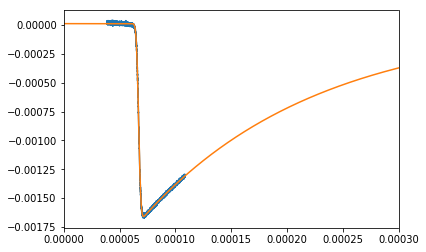

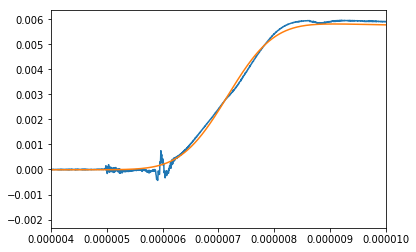

Xe-000_P-01_E-100.txt
1.5972102648486972e-05


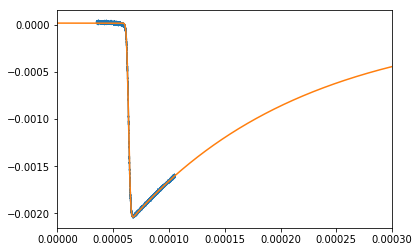

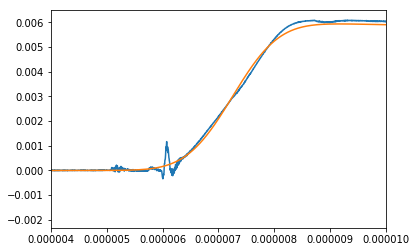

Xe-000_P-01_E-150.txt
1.7769626429805776e-05


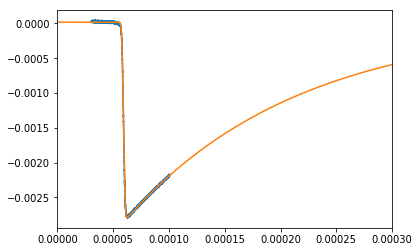

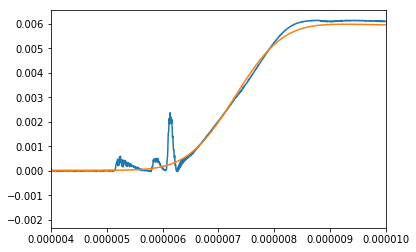

Xe-000_P-01_E-200.txt
1.5882132267601783e-05


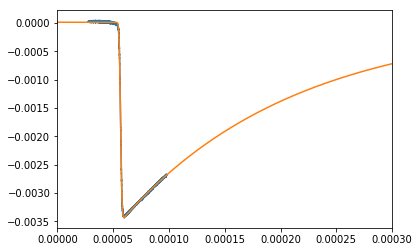

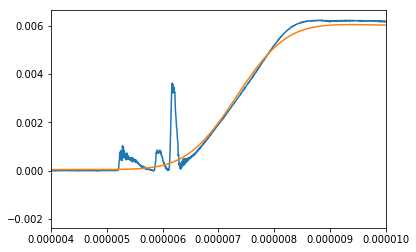

Xe-000_P-01_E-250.txt
1.1151930253408198e-05


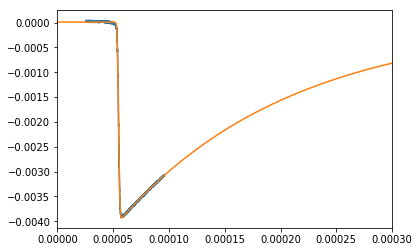

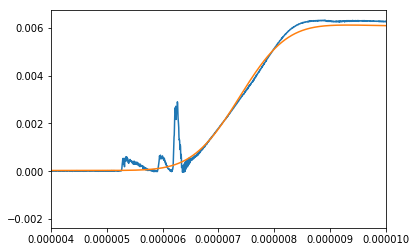

Xe-000_P-01_E-300.txt
1.2110895308356999e-05


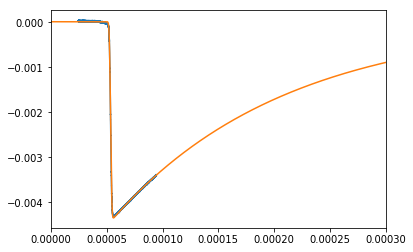

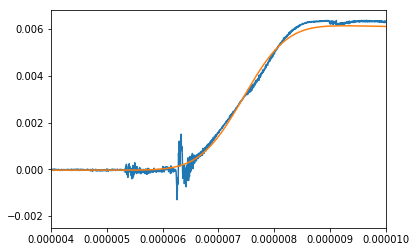

Xe-000_P-03_E-080.txt
4.846930185943465e-06


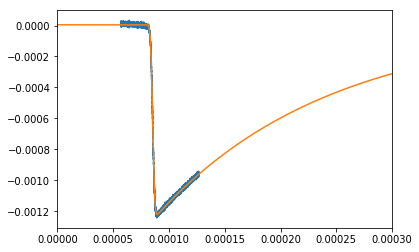

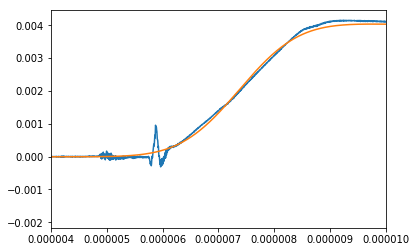

Xe-000_P-03_E-100.txt
4.173037691914709e-06


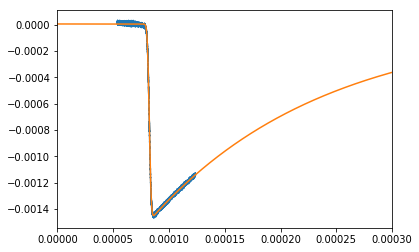

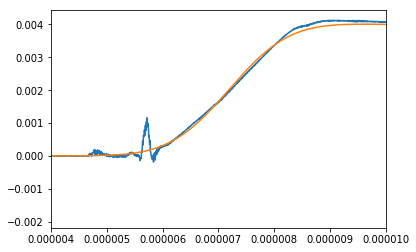

Xe-000_P-03_E-150.txt
3.6022383079911176e-06


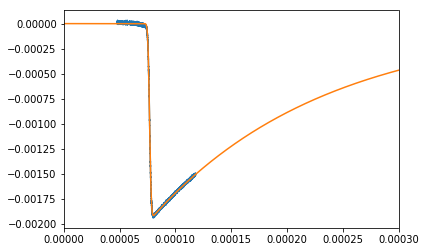

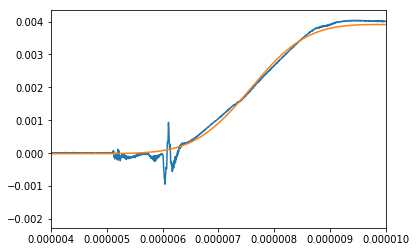

Xe-000_P-03_E-200.txt
-8.548309215266555e-07


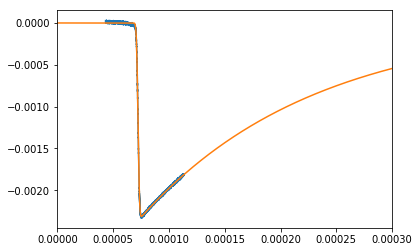

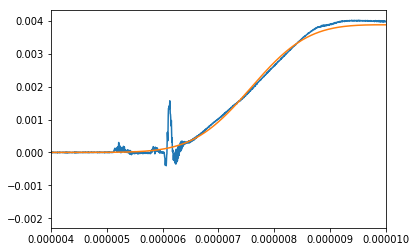

Xe-000_P-03_E-250.txt
2.7644565718420664e-06


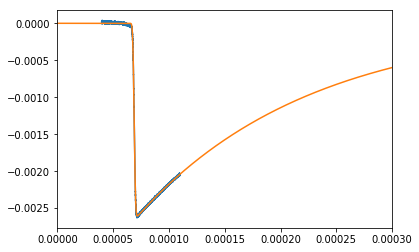

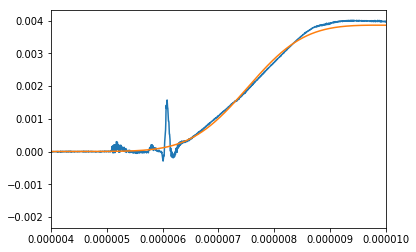

Xe-000_P-03_E-300.txt
6.755973554735722e-07


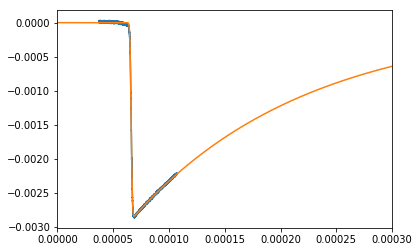

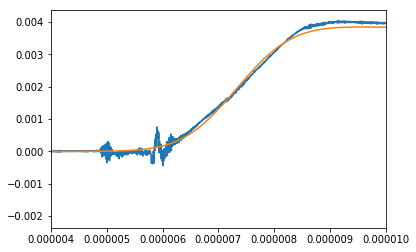

In [14]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
MARKER= dict()
CHIa = []
CHIg = []
for F in range(0,len(folders)):
    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    MarkH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(np.nan_to_num(Data[0]))!=0 and np.mean(np.nan_to_num(Data[1]))!=0:
            xa,ya,opta,chia,cuta = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig,cutg = FITTER_GOLD(Data[0],Data[1])
            CHIa.append(chia)
            CHIg.append(chig)
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            
            print(opta[-1])
            plt.plot(xa[cuta[0]:cuta[1]],ya[cuta[0]:cuta[1]])
            plt.plot(xa,funcA(xa,*opta))
            plt.xlim(0,0.0003)
            plt.show()
            
            plt.plot(xg[cutg[0]:cutg[1]],yg[cutg[0]:cutg[1]])
            plt.plot(xg,funcG(xg,*optg))
            plt.xlim(-0.00002,0.00005)
            plt.xlim(0.000004,0.00001)
            plt.show()
            if PP==1:
                PP = info[0]
                MarkH.append('<')
            elif PP==3:
                PP = info[1]
                MarkH.append('D')
            elif PP==6:
                PP = info[2]
                MarkH.append('s')
            elif PP==9:
                PP = info[3]
                MarkH.append('o')
            elif PP==11 or PP==10:
                PP = info[4]
                MarkH.append('^')
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
    MARKER[F] = np.array(MarkH)  
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct

In [15]:
cuta

[9277, 26777]

In [18]:
(ANODE[0][:,1]*1e6)**2

array([2.60310172, 2.06123437, 1.37156328, 1.05490252, 0.87602958,
       0.75747496, 2.1974896 , 1.92888734, 1.48380447, 1.17172866,
       0.95747418, 0.81236639])

In [19]:
(GOLDD[0][:,1]*1e6)**2

array([0.42065644, 0.42316327, 0.44613796, 0.48897294, 0.43667515,
       0.37093827, 0.6910078 , 0.70541714, 0.63318019, 0.65944495,
       0.64577229, 0.59909049])

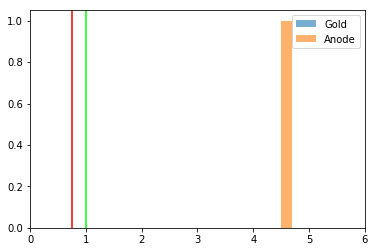

In [79]:
CHIa = np.array(CHIa)*1e6
CHIg = np.array(CHIg)*1e6
plt.hist(CHIg,bins=np.linspace(0,10,50),alpha=0.6,label="Gold")
plt.hist(CHIa,bins=np.linspace(0,10,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.xlim(0,6)
plt.axvline(0.75,color="r")
plt.axvline(1,color="lime")
plt.show()

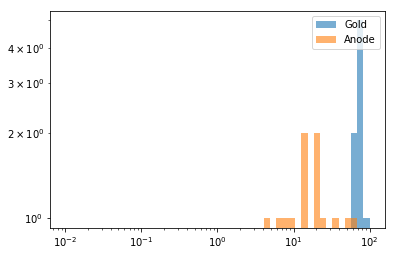

In [80]:
plt.hist(CHIg,bins=np.logspace(-2,2,50),alpha=0.6,label="Gold")
plt.hist(CHIa,bins=np.logspace(-2,2,50),alpha=0.6,label="Anode")
plt.legend(loc="upper right")
plt.loglog()
#plt.xlim(0,6)
#plt.axvline(0.75,color="r")
#plt.axvline(1,color="lime")
#plt.axvline(0.6,color="g")
#plt.axvline(0.8,color="b")
plt.show()

In [81]:
PERCT

{0: '000'}

In [82]:
def Dl(Redu, sigma, time):
    D  = sigma/(2*time)  
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlP(Redu, sigma, time,pre):
    D  = sigma/(2*time)*pre#*np.sqrt(pre)  
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlS(Redu, sigma, time):
    d = 15.12
    D = (sigma*d**2)/(2.0*time**3)*1e6 # Dl slash
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlSstar(Redu, sigma, time, pre):
    d = 15.12
    d = 13.49
    D = (sigma*d**2)/(2.*time**3)*1e6 # Dl slash
    D = 2.*D/(d/(time*1e-6))
    D = np.sqrt(D)*np.sqrt(pre)
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

def DlSP(Redu, sigma, time,pre):
    d = 15.12
    D = (sigma*d**2)/(2*time**3)*1e6*pre#np.sqrt(pre) # Dl slash
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D


def DlSstarP(Redu, sigma, time, pre):
    d = 15.12
    d = 13.49
    D = sigma/(2*time) # Dl slash
    D = 2.*D/(d/(time*1e-6))
    D = np.sqrt(D)*np.sqrt(pre)
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D


def Vel(Redu, time):
    d = 151.2
    D = d/time
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D



In [21]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']

In [22]:
nextDX = np.array([22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0])
nextDY = np.array([1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2])
print(len(nextDX))
print(len(nextDY))

19
19


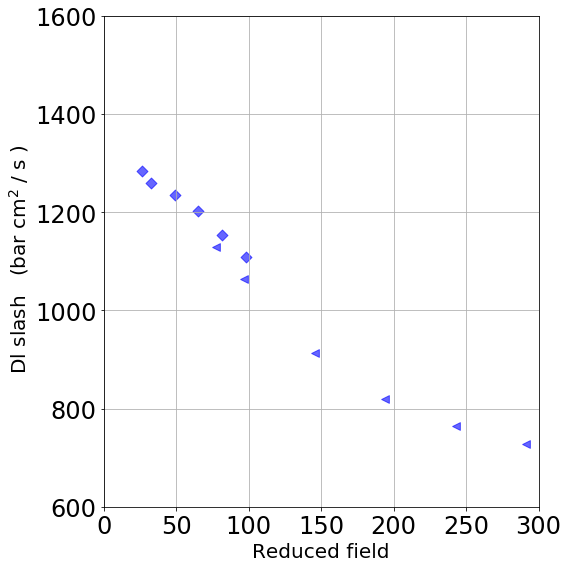

In [26]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #d = 13.48+.16+.398
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = (ANODE[q][:,1]*1e6)**2
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*1e6*PRE[q]
    Dstar  = np.sqrt(2*Dslash/V)#*np.sqrt(PRE[q])
    #Dslash = Dslash*PRE[q]
    
    #D = (sigma*d**2)/(2.0*Dt**3)*1e6
    #Dstar = np.sqrt(PRE[q]*sigma*d)/Dt
    #mark = Mark(REDU[q],PRE[q])
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    #plt.scatter(REDU[q]*1.06-8,Dslash,label=lab,s=40,color='r',alpha=0.6)
    #RR = ((500+EFID[q]*d)/13.64)/PRE[q]
    #RR = ((500+EFID[q]*d+300*0.397)/15.12)/PRE[q]
    #plt.scatter(RR,Dslash,label=lab,s=20,color='r',alpha=0.6)
    #mark = Mark(REDU[q],PRE[q])
    X = REDU[q]
    Y = Dslash
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
plt.ylim(600,1600)
plt.xlim(0,300)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
plt.ylabel(r" Dl slash   (bar cm$^2$ / s )",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [86]:
(ANODE[q][:,1]*1e6)**2

array([2.92691307, 2.31999019, 1.5453871 , 1.19021916, 0.98896271,
       0.85596   , 2.46411212, 2.16411921, 1.66460402, 1.31492112,
       1.07523421, 0.91196573])

In [250]:
(GOLDD[q][:,1]*1e6)**2

array([0.42065644, 0.42316327, 0.44613796, 0.48897294, 0.43667515,
       0.37093827, 0.6910078 , 0.70541714, 0.63318019, 0.65944495,
       0.64577229, 0.59909049])

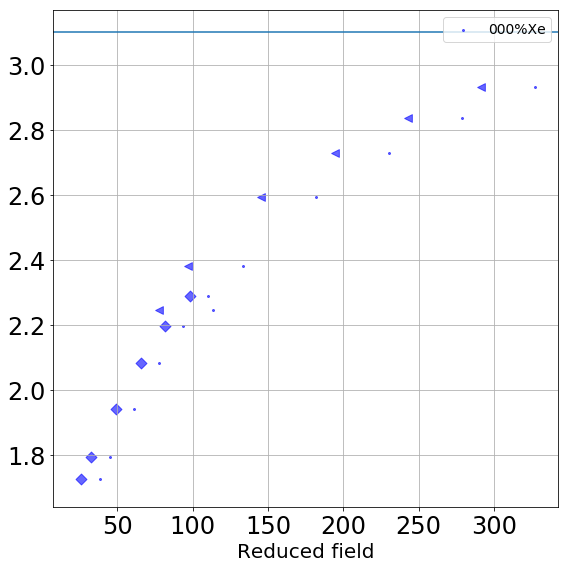

In [266]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48+.16+.398
    d=13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    V = d/Dt
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    #plt.scatter(REDU[q]*1.06-8,Dslash,label=lab,s=40,color='r',alpha=0.6)
    RR = ((3125*.16+EFID[q]*13.48)/d)/PRE[q]
    plt.scatter(RR,V*10,label=lab,s=4,color='b',alpha=0.6)
    #mark = Mark(REDU[q],PRE[q])
    X = REDU[q]
    Y = V*10
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.axhline(3.1)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

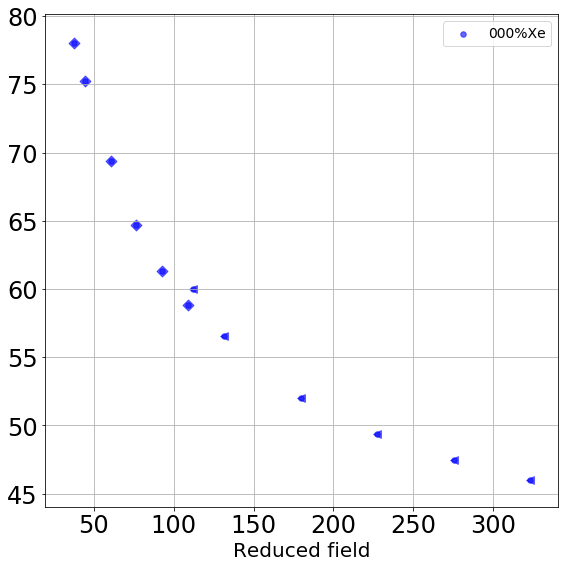

In [182]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2)) - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]
    plt.scatter(RR,Dt,label=lab,s=30,color='b',alpha=0.6)
    
    X = RR
    Y = Dt
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)
    
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

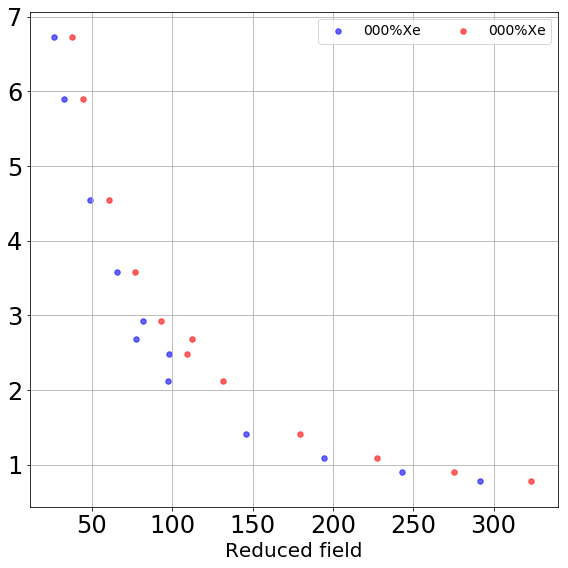

In [207]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2))# - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]

    plt.scatter(REDU[q],sigma*(PRE[q]),label=lab,s=30,color='b',alpha=0.6)
    plt.scatter(RR,sigma*(PRE[q]),label=lab,s=30,color='r',alpha=0.6)

    '''X = RR
    Y = Dt
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)'''
    
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6

    d = 15.12
    d = 13.48
    #sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) #- (((GOLDD[q][:,1]*1e6))**2-2.58)
    sigma = ((((ANODE[q][:,1]*1e6))**2)) - (((GOLDD[q][:,1]*1e6))**2)
    V = d/Dt
    Dslash = sigma*V**3/(2*d)*PRE[q]*1e6
    Dstar  = np.sqrt(2*Dslash/V)*np.sqrt(PRE[q])
    
    #D = (sigma*d**2)/(2.0*Dt**3)*1e6
    #Dstar = np.sqrt(PRE[q]*sigma*d)/Dt
    #mark = Mark(REDU[q],PRE[q])
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    #plt.scatter(REDU[q]*1.06-8,Dslash,label=lab,s=40,color='r',alpha=0.6)
    RR = ((500+EFID[q]*d)/13.64)/PRE[q]
    plt.scatter(RR,V*10,label=lab,s=4,color='b',alpha=0.6)
    #mark = Mark(REDU[q],PRE[q])
    X = REDU[q]
    Y = V*10
    mark = MARKER[q]
    for x, y, m in zip(X, Y, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY,color='lime')
#plt.errorbar(nextDX,nextDY,xerr=0,yerr=80,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')


#plt.ylim(0,1000)
#plt.xlim(0,200)
#plt.xlim(0,400)
#plt.axhline(500)
#plt.ylim(0,1600)
#plt.xlim(0,300)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

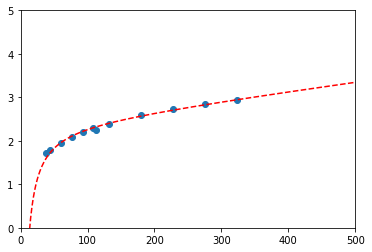

In [190]:
ReduCor = ((500+EFID[q]*d)/13.64)/PRE[q]
X = ReduCor
V = 13.48/((ANODE[q][:,0] - GOLDD[q][:,0])*1e6)
V = V*10
plt.scatter(X,V)

xt = np.linspace(1,5000,5000)
cof = np.polyfit(X,X*V,2)
fit = np.poly1d(cof)

plt.plot(xt,fit(xt)/xt,'--r')


plt.xlim(0,500)
plt.ylim(0,5)
plt.show()


### 

In [192]:
dex = []
for x in range(0,len(ReduCor)):
    fn = find_nearest(xt,3125/PRE[0][x])
    loc = np.where(xt==fn)[0][0]
    dex.append(loc)
dex = np.array(dex)

dex2 = []
for x in range(0,len(ReduCor)):
    fn = find_nearest(xt,300/PRE[0][x])
    loc = np.where(xt==fn)[0][0]
    dex2.append(loc)
dex2 = np.array(dex2)

0.757474958849191
[-0.77769097  1.4644948 ]
0.37093827368230503
[0.18352096 0.07382592]


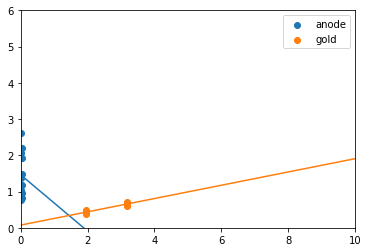

In [205]:
sig = ((ANODE[0][:,1]*1e6))**2 - ((GOLDD[0][:,1]*1e6))**2
Dt = (ANODE[0][:,0] - GOLDD[0][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,300,1000)

xx = 1/(fit(xt[dex])/xt[dex])
xx = (1/(fit(xt[dex])/xt[dex]))**2

here = np.where((xx >= 0) & (xx <=300))
yy = ((ANODE[0][:,1]*1e6))**2
print(min(yy))
plt.scatter(xx[here],yy[here],label="anode")

coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))


xx = 4/(fit(xt[dex2])/xt[dex2])
xx = (4/(fit(xt[dex2])/xt[dex2]))**2
here = np.where((xx >= 0) & (xx <=200))
yy = ((GOLDD[0][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))

'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
plt.ylim(0,6)
plt.xlim(0,10)
plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [288]:
sigma

array([ 14.01964022,  17.99868319,  10.96646098,  11.07266524,
        17.7720679 ,  18.74316934,  12.28253649,  11.85010323,
         7.92648025, 113.57666731,  44.06995089,  15.52592727,
        12.57533878,   9.64830026, 613.14392099, 167.04092323,
        29.19478862,  17.59146584, 346.31745725,  54.84703902,
        12.41412314])

[  0.53611581 -43.88639445]
[  0.55817979 -52.53826417]


(0, 200)

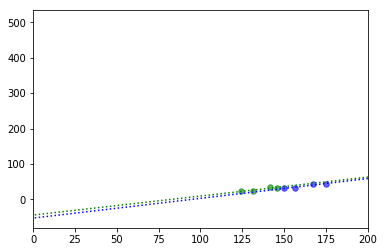

In [213]:
EP = np.linspace(1,1000,10000)


sort_index = np.argsort(REDU[6])
Redu = REDU[6][sort_index]
sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) - (((GOLDD[q][:,1]*1e6))**2-2.58)
sigma = ((((ANODE[q][:,1]*1e6))**2)-0)# - (((GOLDD[q][:,1]*1e6))**2-2.58)


plt.scatter(Dt[0:4],sigma[0:4],label=lab,s=30,color='g',alpha=0.6)
cof1 = np.polyfit(Dt[0:4],sigma[0:4],1)
print(cof1)
fit1 = np.poly1d(cof1)
plt.plot(EP,fit1(EP),':g')

plt.scatter(Dt[4:8],sigma[4:8],label=lab,s=30,color='b',alpha=0.6)
cof1 = np.polyfit(Dt[4:8],sigma[4:8],1)
print(cof1)
fit1 = np.poly1d(cof1)
plt.plot(EP,fit1(EP),':b')

'''

Y    = (sigma*PRE[6])[sort_index]
#Y    = (sigma)[sort_index]
#drop = np.argwhere(np.isnan(Y))
Redu = Redu[~np.isnan(Y)]
Y    = Y[~np.isnan(Y)]

#plt.scatter(1000/Redu,Y,label=lab,s=30,color='g',alpha=0.6)
plt.scatter(Redu,1/(Y*Redu),label=lab,s=30,color='g',alpha=0.6)
cof = np.polyfit(1000/Redu,Y,4)
fit = np.poly1d(cof)
'''
#plt.plot(EP,fit(1000/EP),':r')
plt.xlim(0,200)
#plt.ylim(0,200)

In [207]:
PRE[6][4:8]

array([3.02, 3.02, 3.02, 3.02])

In [214]:
sigma[4:8]

array([44.02384631, 43.05963425, 33.7119119 , 31.39624926])

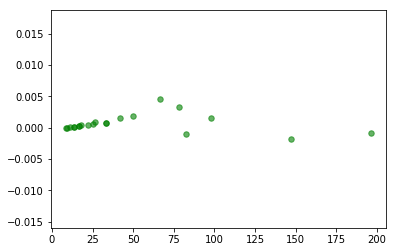

In [134]:
EP = np.linspace(1,200,1000)


sort_index = np.argsort(REDU[6])
Redu = REDU[6][sort_index]
sigma = ((((ANODE[q][:,1]*1e6))**2)-28.7) - (((GOLDD[q][:,1]*1e6))**2-2.58)
Y    = (sigma*PRE[6])[sort_index]
#Y    = (sigma)[sort_index]
#drop = np.argwhere(np.isnan(Y))
Redu = Redu[~np.isnan(Y)]
Y    = Y[~np.isnan(Y)]

#plt.scatter(1000/Redu,Y,label=lab,s=30,color='g',alpha=0.6)
plt.scatter(Redu,1/(Y*Redu),label=lab,s=30,color='g',alpha=0.6)
cof = np.polyfit(1000/Redu,Y,4)
fit = np.poly1d(cof)

#plt.plot(EP,fit(1000/EP),':r')
#plt.xlim(0,.20)
#plt.ylim(-20,200)

In [126]:
Y

array([630.00210759, 362.65112556, 175.8271779 , 119.27288314,
        57.50558468,  29.20721375,  45.27249863,  10.37598189,
        13.11466248,  11.52213413,  14.04277136,  13.20849303,
         6.14677921,   2.58649952,   3.69917717,   1.09371118,
         3.70745129,  -3.94592466,   6.23867634,  -3.69123035,
        -5.69862742])

In [58]:
[~np.isnan(Y)]

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False, False])]

In [57]:
Y[~np.isnan(Y)]

array([75.29952834, 63.18851868, 39.77995225, 26.72909594, 25.16220355,
       16.21310963, 16.46761266, 10.68829082, 10.86425158,  8.30768219,
        6.5122323 ,  6.31582528,  6.06788328,  3.93613162,  3.34238164,
        1.81741788,  1.94463372,  2.52258793])

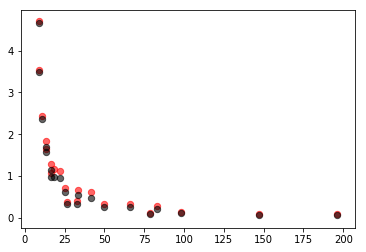

In [83]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
sig2 = ((ANODE[6][:,1]*1e6))**2 - 6.82
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
X,Y = DlP(REDU[6],sig2,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='k',alpha=0.6)

(0, 0.4)

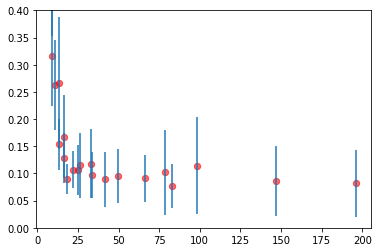

In [110]:
sig1 = (ANODE[6][:,1]*1e6)**2
sig2 = (GOLDD[6][:,1]*1e6)**2
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

D = sig/(2*Dt)
frac_err = np.sqrt((2*1/sig1)**2+(2*1/sig2)**2+(2*1/Dt)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[6],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[6],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.ylim(0,0.4)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


In [ ]:
def DlSstar(Redu, sigma, time, pre):
    d = 15.12
    d = 13.49
    D = (sigma*d**2)/(2.*time**3)*1e6 # Dl slash
    D = 2.*D/(d/(time*1e-6))
    D = np.sqrt(D)*np.sqrt(pre)
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

[]

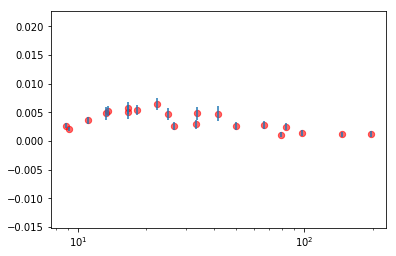

In [135]:
sig1 = (ANODE[6][:,1]*1e6)**2
sig2 = (GOLDD[6][:,1]*1e6)**2
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

D = sig*(15.12)**2/(2*Dt**3)*PRE[6]
#D = np.sqrt(D)*1e4/2
#D = 2*D/(15.12/(Dt*1e-6))
frac_err = np.sqrt((2*0.5/sig1)**2+(2*0.5/sig2)**2+(6*0.5/Dt)**2+(2*0.1/15)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[6],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[6],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.semilogx()
#plt.ylim(0,0.004)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


[]

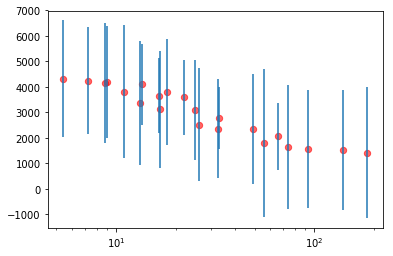

In [127]:
sig1 = (ANODE[0][:,1]*1e6)**2
sig2 = (GOLDD[0][:,1]*1e6)**2
sig = ((ANODE[0][:,1]*1e6))**2 -((GOLDD[0][:,1]*1e6))**2
Dt = (ANODE[0][:,0] - GOLDD[0][:,0])*1e6

D = sig*(15.12)/(Dt**2)*PRE[0]
D = np.sqrt(D)*1e4
#D = 2*D/(15.12/(Dt*1e-6))
frac_err = np.sqrt((2*0.5/sig1)**2+(2*0.5/sig2)**2+(2*0.5/Dt)**2+(0.1/15)**2)
frac_err = D*frac_err
#X,Y = DlP(Dt,sig,Dt,PRE[6])
plt.scatter(REDU[0],D,label=lab,s=40,color='r',alpha=0.6)
plt.errorbar(REDU[0],D,yerr=frac_err,fmt='D', capthick=1,markersize=0)
plt.semilogx()
#plt.ylim(0,0.004)
#for x, y, m in zip(X, Y, mark):
#        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 


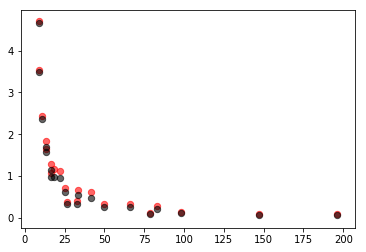

In [142]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
sig2 = ((ANODE[6][:,1]*1e6))**2 - 6.82
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
X,Y = DlP(REDU[6],sig2,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='k',alpha=0.6)

(0, 5)

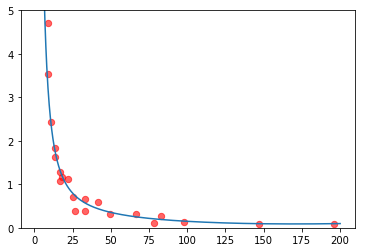

In [198]:
sig1 = ((ANODE[6][:,1]*1e6))**2 - 0
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6

X,Y = DlP(REDU[6],sig1,Dt,PRE[6])

xt = np.linspace(1,200,1000)
cof = np.polyfit(X,X**2*Y,4)
fit = np.poly1d(cof)
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)

plt.plot(xt,fit(xt)/xt**2)
plt.ylim(0,5)


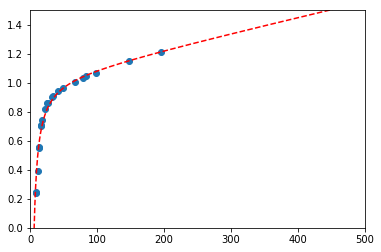

In [177]:
X,V = Vel(REDU[6],Dt)

plt.scatter(X,V)

xt = np.linspace(1,500,1000)
cof = np.polyfit(X,X*V,2)
fit = np.poly1d(cof)

plt.plot(xt,fit(xt)/xt,'--r')


plt.xlim(0,500)
plt.ylim(0,1.5)
plt.show()


In [178]:
((ANODE[6][:,1]*1e6))#**2

array([ 5.69699833,  5.91103626,  5.00917935,  4.80796383,  6.63504682,
        6.56198402,  5.80619599,  5.60323561,  5.10048852, 12.23785509,
        8.70785259,  6.50653224,  6.06902027,  5.68137723, 25.7376514 ,
       14.43129839,  7.80714637,  6.75378915, 19.88970175,  9.49840795,
        6.54963741])

In [179]:
((GOLDD[6][:,1]*1e6))#**2

array([1.6212152 , 1.60675864, 1.63190321, 1.64168924, 1.96496182,
       1.93161622, 1.97300145, 2.04512544, 1.95982341, 2.09098402,
       2.10575356, 2.16629352, 2.13687339, 1.8898539 , 2.51089462,
       2.51300525, 2.37156502, 2.5256693 , 2.6132566 , 2.5679114 ,
       2.5301716 ])

In [256]:
dex = []
for x in range(0,len(REDU[6])):
    fn = find_nearest(xt,2*REDU[6][x])
    loc = np.where(xt==fn)[0][0]
    dex.append(loc)
dex = np.array(dex)

dex2 = []
for x in range(0,len(REDU[6])):
    fn = find_nearest(xt,300/PRE[6][x])
    loc = np.where(xt==fn)[0][0]
    dex2.append(loc)
dex2 = np.array(dex2)

In [259]:
15/(fit(xt[dex])/xt[dex])

array([12.88120135, 12.34807671, 11.27513861, 10.41127553, 15.3709468 ,
       14.79351832, 13.88756201, 13.26330707, 12.75917419, 18.04704602,
       16.90593718, 15.53323244, 14.77562232, 14.2712201 , 21.06050819,
       19.26117988, 16.90593718, 15.88080031, 21.06050819, 17.84248949,
       16.56359393])

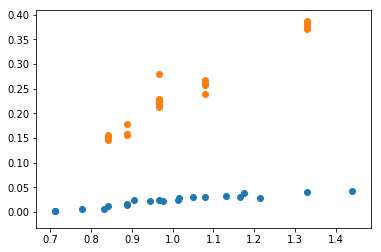

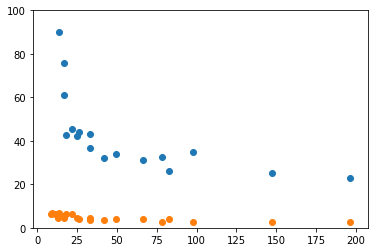

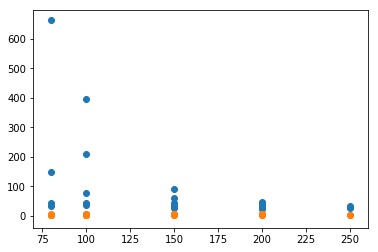

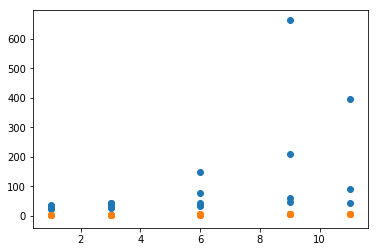

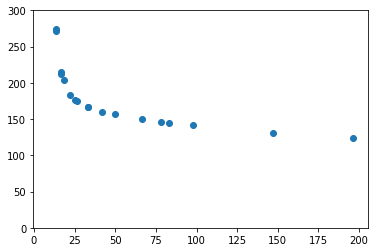

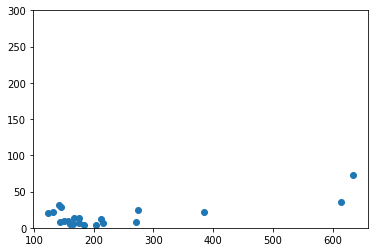

In [182]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

plt.scatter(fit(xt[dex])/xt[dex],1/((ANODE[6][:,1]*1e6))**2)
plt.scatter(fit(xt[dex2])/xt[dex2],1/((GOLDD[6][:,1]*1e6))**2)

#plt.scatter(vv,1/sig)

plt.show()


plt.scatter(REDU[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(REDU[6],((GOLDD[6][:,1]*1e6))**2)
plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(EFID[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(EFID[6],((GOLDD[6][:,1]*1e6))**2)
#plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(PRE[6],((ANODE[6][:,1]*1e6))**2)
plt.scatter(PRE[6],((GOLDD[6][:,1]*1e6))**2)
#plt.ylim(0,100)
#plt.scatter(vv,1/sig)

plt.show()

plt.scatter(REDU[6],Dt)
plt.ylim(0,300)
#plt.scatter(vv,1/sig)

plt.show()


plt.scatter(Dt,sig/PRE[6])
plt.ylim(0,300)
#plt.scatter(vv,1/sig)

plt.show()

23.116516158866325
[ 0.21149923 -4.23971831]
2.5816733403232868
[ 0.29542919 -0.20030239]


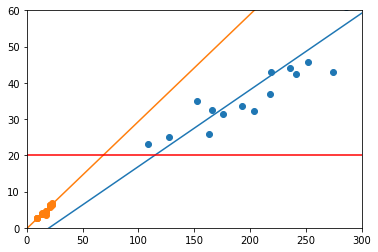

In [280]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,300,1000)

xx = 15/(fit(xt[dex])/xt[dex])
xx = (15/(fit(xt[dex])/xt[dex]))**2

here = np.where((xx >= 0) & (xx <=300))
yy = ((ANODE[6][:,1]*1e6))**2
print(min(yy))
plt.scatter(xx[here],yy[here],label="anode")

coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))


xx = 4/(fit(xt[dex2])/xt[dex2])
xx = (4/(fit(xt[dex2])/xt[dex2]))**2
here = np.where((xx >= 0) & (xx <=200))
yy = ((GOLDD[6][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))

'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
plt.axhline(20,color='r')
plt.ylim(0,60)
plt.xlim(0,300)
#plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [298]:
15/(fit(xt[dex])/xt[dex])

array([12.88120135, 12.34807671, 11.27513861, 10.41127553, 15.3709468 ,
       14.79351832, 13.88756201, 13.26330707, 12.75917419, 18.04704602,
       16.90593718, 15.53323244, 14.77562232, 14.2712201 , 21.06050819,
       19.26117988, 16.90593718, 15.88080031, 21.06050819, 17.84248949,
       16.56359393])

In [304]:
xx = (.235*15.8/(fit(xt[dex])/xt[dex]))**2
CORR =xx
CORR

array([10.16670256,  9.34256263,  7.78952831,  6.64163892, 14.47666816,
       13.40943032, 11.81733107, 10.77881527,  9.97499102, 19.95628198,
       17.51240863, 14.78396967, 13.37700666, 12.4792817 , 27.17722272,
       22.73176484, 17.51240863, 15.45297671, 27.17722272, 19.50645183,
       16.81034126])

In [255]:
15/fit(xt[dex])/xt[dex]

array([5.23626255e-04, 3.20434799e-04, 1.30262146e-04, 6.77161556e-05,
       5.48279936e-03, 3.35185320e-03, 1.40553284e-03, 7.56978236e-04,
       4.66757393e-04, 2.57484701e-02, 1.50936248e-02, 6.22550118e-03,
       3.29801844e-03, 2.05091482e-03, 6.51246466e-02, 3.98719852e-02,
       1.50936248e-02, 8.03531116e-03, 6.51246466e-02, 2.36389569e-02,
       1.24570410e-02])

In [243]:
PRE[6][18:]

array([11.01, 11.01, 11.01])

23.116516158866325
[2.29102445e+05 2.29327893e+01]
26.014983151966952
[3.39779130e+04 2.78509227e+01]
32.27804727112549
[4.85567097e+04 1.65040780e+01]
45.61366789745632
[ 1.06113098e+05 -9.55814553e+01]
42.89775022426224
[ 6.87754160e+04 -5.58104849e+01]


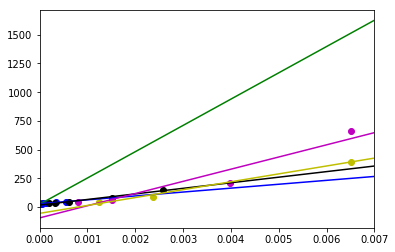

In [246]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

xxt = np.linspace(0,0.007,1000)

xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[0:4]
xx = xx[0:4]
print(min(yy))
plt.scatter(xx,yy,color='g',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'g')



xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[4:9]
xx = xx[4:9]
print(min(yy))
plt.scatter(xx,yy,color='b',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'b')

xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[9:14]
xx = xx[9:14]
print(min(yy))
plt.scatter(xx,yy,color='k',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'k')


xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[14:18]
xx = xx[14:18]
print(min(yy))
plt.scatter(xx,yy,color='m',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'m')


xx = 1.5/fit(xt[dex])/xt[dex]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((ANODE[6][:,1]*1e6))**2
yy = yy[18:]
xx = xx[18:]
print(min(yy))
plt.scatter(xx,yy,color='y',label="anode")

coff = np.polyfit(xx,yy,1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt),'y')

'''
xx = 0.4/fit(xt[dex2])/xt[dex2]
here = np.where((xx >= 0) & (xx <=0.002))
yy = ((GOLDD[6][:,1]*1e6))**2
print(min(yy))

plt.scatter(xx[here],yy[here],label="gold")
coff = np.polyfit(xx[here],yy[here],1)
print(coff)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
'''xxt = np.linspace(0,0.002,1000)
xx = 1/fit(xt[dex])/xt[dex]
yy = ((ANODE[6][:,1]*1e6))**2

coff = np.polyfit(xx,yy,2)
ffit = np.poly1d(coff)
plt.plot(xxt,ffit(xxt))
'''
#plt.axhline(23.1,color='r')
#plt.ylim(0,100)
plt.xlim(0,0.007)
#plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [247]:
PRE[6]

array([ 1.02,  1.02,  1.02,  1.02,  3.02,  3.02,  3.02,  3.02,  3.02,
        5.99,  5.99,  5.99,  5.99,  5.99,  9.  ,  9.  ,  9.  ,  9.  ,
       11.01, 11.01, 11.01])

In [248]:
CORR = np.array([22.9,22.9,22.9,22.9,27.8,27.8,27.8,27.8,27.8,16.5,16.5,16.5,16.5,16.5,0,0,0,0,0,0,0])

In [185]:
xx = 1.5/fit(xt[dex])/xt[dex]
1/xx

array([ 19097.5908919 ,  31207.59677898,  76768.27285929, 147675.24684479,
         1823.88582014,   2983.42421596,   7114.73950051,  13210.41943636,
        21424.4062325 ,    388.37258905,    662.53137372,   1606.29637762,
         3032.12373475,   4875.87289749,    153.55169686,    250.80266107,
          662.53137372,   1244.50687748,    153.55169686,    423.03051099,
          802.75885449])

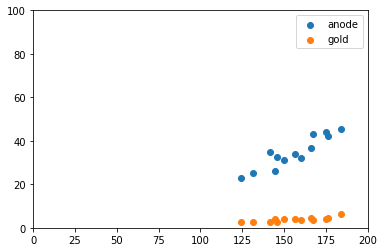

In [172]:
sig = ((ANODE[6][:,1]*1e6))**2 - ((GOLDD[6][:,1]*1e6))**2
Dt = (ANODE[6][:,0] - GOLDD[6][:,0])*1e6
vv = 15.12/Dt

plt.scatter(Dt,((ANODE[6][:,1]*1e6))**2,label="anode")
plt.scatter(Dt,((GOLDD[6][:,1]*1e6))**2,label="gold")

plt.ylim(0,100)
plt.xlim(0,200)
plt.legend()
#plt.scatter(vv,1/sig)

plt.show()


In [270]:
V1 = fit(xt[dex2])/xt[dex2]
V2 = (13.49/Dt)
V3 = fit(xt[dex])/xt[dex]

In [273]:
V1

array([1.33036058, 1.33036058, 1.33036058, 1.33036058, 1.08010319,
       1.08010319, 1.08010319, 1.08010319, 1.08010319, 0.96567151,
       0.96567151, 0.96567151, 0.96567151, 0.96567151, 0.88726226,
       0.88726226, 0.88726226, 0.88726226, 0.84068986, 0.84068986,
       0.84068986])

In [269]:
V2

array([0.09241625, 0.09538581, 0.10272436, 0.10847957, 0.07701197,
       0.08067232, 0.08606262, 0.08992104, 0.09331993, 0.04929775,
       0.06341115, 0.07651337, 0.08118997, 0.08432836, 0.02129271,
       0.03501343, 0.06269373, 0.07336295, 0.02197301, 0.04966644,
       0.06623979])

In [271]:
V3

array([1.16448766, 1.21476408, 1.33036058, 1.44074566, 0.97586702,
       1.01395758, 1.08010319, 1.13093966, 1.17562467, 0.83116095,
       0.88726226, 0.96567151, 1.01518567, 1.0510664 , 0.71223353,
       0.77876849, 0.88726226, 0.94453678, 0.71223353, 0.84068986,
       0.90560056])

In [274]:
((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt

array([ 82.02987145, 102.38402746, 153.26262366, 204.07423312,
        82.03825185, 102.43374975, 153.36676037, 204.27696725,
       255.18177564,  81.50933204, 102.17348709, 153.34788732,
       204.30499869, 255.23740316,  80.74534837, 101.35088796,
       152.98562336, 204.19011475, 100.91858278, 152.49626166,
       203.95417488])

In [280]:
cc = V2/V3

In [277]:
Eeff = ((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt
Eeff = ((0.4*300)+(13.49*EFID[6])+(1.5*2*EFID[6]))/15.12

EFID[6]/Eeff

array([0.84046693, 0.85472018, 0.87449393, 0.88472791, 0.84046693,
       0.85472018, 0.87449393, 0.88472791, 0.89098409, 0.84046693,
       0.85472018, 0.87449393, 0.88472791, 0.89098409, 0.84046693,
       0.85472018, 0.87449393, 0.88472791, 0.85472018, 0.87449393,
       0.88472791])

In [286]:
sig

array([-0.05257725,  0.1619157 , -0.72562804, -0.95460755, -0.38686897,
       -0.30523789, -1.20656974, -1.68622147, -1.77586403,  4.51064171,
        0.98500943, -1.33848748, -1.62049025, -0.98183991, 13.49910726,
        3.04828069, -1.31750029, -2.83615436,  5.37549461, -1.26414896,
       -3.26402974])

/Users/austinmcdonald/miniconda/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


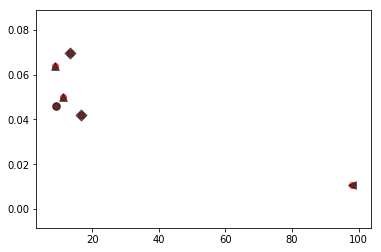

In [285]:
sig = ((ANODE[6][:,1]*1e6))**2*cc -((GOLDD[6][:,1]*1e6))**2

#Eeff = ((0.4/V1*300)+(13.49/V2*EFID[6])+(1.5/V3*2*EFID[6]))/Dt
#Eeff = ((0.4*300)+(13.49*EFID[6])+(1.5*2*EFID[6]))/15.12

#Eeff = Eeff/PRE[6]
X,Y = DlSstar(REDU[6],sig,Dt,PRE[6])
plt.scatter(X,Y,label=lab,s=40,color='r',alpha=0.6)
for x, y, m in zip(X, Y, mark):
    plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60)

In [250]:
factor1 = 15.12/(15.12/Dt)**3
factor2 = 13.49/(15.12/Dt)**3
factor3 = 1.500/(fit(xt[dex])/xt[dex])**3

In [257]:
factor1

array([  13604.64519884,   12373.17077148,    9906.31039771,
          8411.78983865,   23510.26973872,   20453.07473459,
         16845.68294498,   14768.90407645,   13213.23140148,
         89629.47599789,   42114.85568413,   23972.88121621,
         20064.35373937,   17906.52220186, 1112345.14122128,
        250165.99484057,   43577.2578742 ,   27195.80694981,
       1012193.40609638,   87648.24794698,   36946.68525351])

In [258]:
factor2

array([ 12138.00686061,  11039.29058911,   8838.36820536,   7504.96328858,
        20975.76314651,  18248.14670434,  15029.64701903,  13176.75370313,
        11788.78912738,  79967.0391013 ,  37574.69597744,  21388.50314859,
        17901.33147778,  15976.12331369, 992429.6266584 , 223197.04169308,
        38879.44502136,  24263.98384609, 903074.67250265,  78199.39582042,
        32963.6761951 ])

In [259]:
factor3

array([0.94991903, 0.83678799, 0.63706413, 0.5015674 , 1.61405876,
       1.43890428, 1.19040712, 1.03698615, 0.92317744, 2.61237705,
       2.1475102 , 1.66572386, 1.43368858, 1.2918164 , 4.15168143,
       3.17589506, 2.1475102 , 1.78005998, 4.15168143, 2.52454915,
       2.01967368])

In [260]:
(factor2+factor3)

array([ 12138.95677964,  11040.1273771 ,   8839.00526949,   7505.46485599,
        20977.37720527,  18249.58560862,  15030.83742615,  13177.79068928,
        11789.71230482,  79969.65147834,  37576.84348764,  21390.16887244,
        17902.76516636,  15977.4151301 , 992433.77833983, 223200.21758814,
        38881.59253155,  24265.76390607, 903078.82418409,  78201.92036958,
        32965.69586878])

In [57]:
fit

array([199.99921198, 200.26685343, 177.17742021,          inf])

In [ ]:
((ANODE[q][:,1]*1e6))**2

In [ ]:
sig[10:14]

In [41]:
np.mean((GOLDD[6][:,1]*1e6)**2)

4.579135073721043

In [42]:
np.min((GOLDD[6][:,1]*1e6)**2)

2.5816733403232868

In [43]:
np.max((GOLDD[6][:,1]*1e6)**2)

6.829110069636839

In [27]:
np.mean(GOLDD[6][:,0])

9.610901393946968e-06

In [28]:
np.std(GOLDD[6][:,0])

5.836574494575003e-07

(4e-06, 1.5e-05)

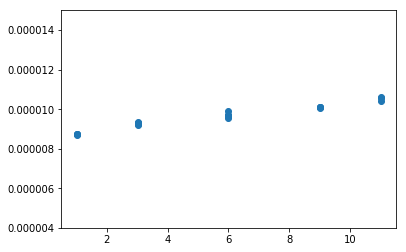

In [35]:
plt.scatter(PRE[6],GOLDD[6][:,0])
plt.ylim(4e-6,15e-6)

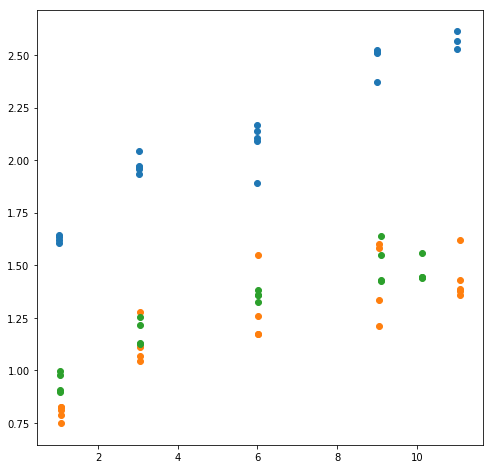

In [25]:
sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
plt.figure(figsize=(8,8))
plt.scatter(PRE[6],((GOLDD[6][:,1]*1e6)))
plt.scatter(PRE[0],((GOLDD[0][:,1]*1e6)))
plt.scatter(PRE[3],((GOLDD[3][:,1]*1e6)))

#plt.ylim(0,3e-6)


In [393]:
((ANODE[q][:,1]*1e6))**2 

array([ 32.45579001,  34.94034968,  25.09187773,  23.11651616,
        44.02384631,  43.05963425,  33.7119119 ,  31.39624926,
        26.01498315, 149.76509731,  75.82669668,  42.33496174,
        36.8330071 ,  32.27804727, 662.42669936, 208.26237328,
        60.9515344 ,  45.6136679 , 395.60023563,  90.21975361,
        42.89775022])

In [189]:
((GOLDD[q][:,1]*1e6))**2 

array([2.62833872, 2.58167334, 2.66310808, 2.69514357, 3.86107494,
       3.73114122, 3.89273473, 4.18253808, 3.84090781, 4.37221418,
       4.43419805, 4.69282761, 4.56622788, 3.57154775, 6.30459177,
       6.31519538, 5.62432065, 6.37900542, 6.82911007, 6.59416893,
       6.40176834])

In [110]:
(ANODE[q][:,1]*1e6)**2

array([ 32.77145021,  34.43900766,  25.43437458,  23.21046121,
        43.53478642,  43.25632884,  34.56631805,  31.85903693,
        26.45221796, 151.30462781,  76.71777643,  43.06938059,
        36.38395019,  32.37520688, 652.30921487, 203.79117006,
        60.90015068,  45.45184619, 383.98568615,  90.48090868,
        43.56450474])

In [111]:
(GOLDD[q][:,1]*1e6)**2

array([2.62833872, 2.58167334, 2.66310808, 2.69514357, 3.86107494,
       3.73114122, 3.89273473, 4.18253808, 3.84090781, 4.37221418,
       4.43419805, 4.69282761, 4.56622788, 3.57154775, 6.30459177,
       6.31519538, 5.62432065, 6.37900542, 6.82911007, 6.59416893,
       6.40176834])

In [20]:
np.mean((ANODE[0][:,1]*1e6)**2)

12.01053883948868

In [21]:
np.mean((ANODE[6][:,1]*1e6)**2)

81.29249988218403

In [22]:
np.mean((GOLDD[0][:,1]*1e6)**2)

1.5276097215585354

In [23]:
np.mean((ANODE[0][:,1]*1e6)**2)

12.01053883948868

In [24]:
np.mean((GOLDD[0][:,1]*1e6)**2)

1.5276097215585354

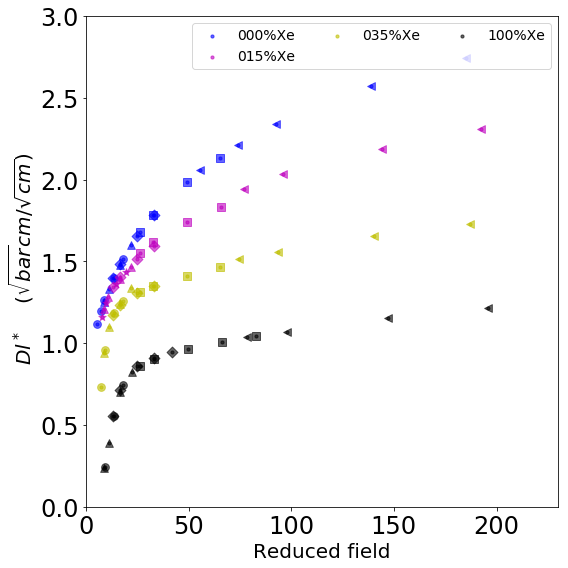

In [258]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [0,3,4,6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2



    mark = Mark(REDU[q],PRE[q])
    X,Y = DlS(REDU[q],sig,Dt)
    #X,Y = Dl(REDU[q],sig,Dt)
    X,Y = DlP(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSP(REDU[q],sig,Dt,PRE[q])
    X,V = Vel(REDU[q],Dt)
    
    X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    #X,Y = DlSstar(REDU[q],sig,Dt,1)
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    #plt.scatter(REDU[q],np.sqrt(PRE[q])/PRE[q])
    plt.scatter(X,V,label=lab,s=10,color=color,alpha=0.6)
    for x, y, m in zip(X, V, mark):
        plt.scatter(x, y, alpha=0.6,marker=m,color=color,s=60) 

#plt.scatter(nextDX,nextDY/1e4,color='lime')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
plt.ylim(0,3)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [43]:
def TTtot(P, E, mu):
    K = 0.4/300
    deff=14.3
    TT = (P/mu)*(K + deff/E)
    return TT

def Ttot(X, mu):
    P,E = X
    K = 0.4/300
    deff=14.3
    TT = (P/mu)*(K + deff/E)
    return TT

In [211]:
def Vel(Redu, time):
    d = 143+4
    D = d/time
    sort_index = np.argsort(Redu)
    Re = Redu[sort_index]
    D  = D[sort_index]
    return  Re, D

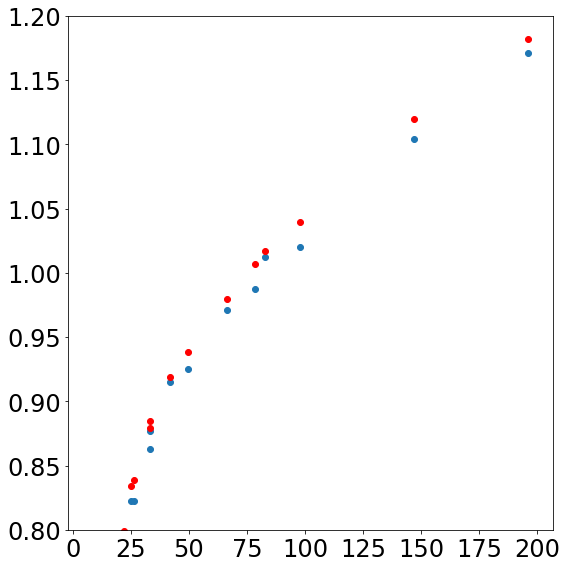

In [213]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2

    K = 4/300
    deff=143
    X = PRE[q]*(K+deff/EFID[q])
    Y = Dt
    #params,er = optimize.curve_fit(Ttot, (PRE[q],EFID[q]), Y)
    
    #sort_index = np.argsort(Dt)
    #XX = Dt[sort_index]
    #YY  = Ttot((PRE[q],EFID[q]),0.00299782)[sort_index]
 
    #plt.plot(XX,YY)
    plt.scatter(REDU[q],(X/Y)*REDU[q])
    X,V = Vel(REDU[q],Dt)
    plt.scatter(X,V,color='r')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)
plt.ylim(0.8,1.2)
#plt.xlim(0,230)
#plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
#plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [67]:
params

array([0.00299782])

In [102]:
K

0.0013333333333333335

In [71]:
K/0.00299782

0.44476764226449

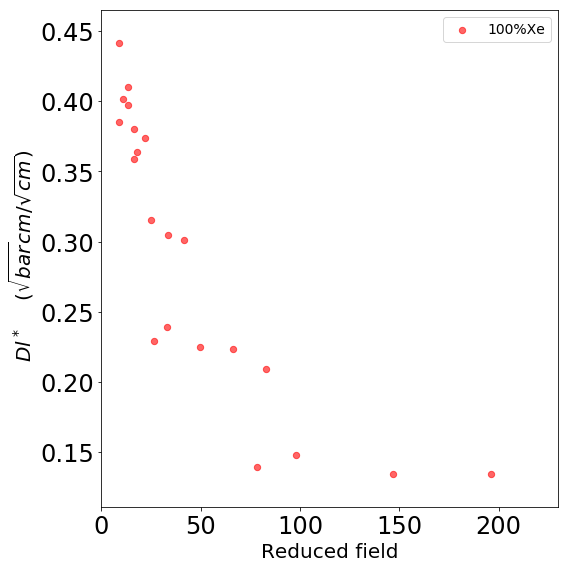

In [112]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
#for q in range(0,7):
for q in [6]:

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2

    #X,Y = DlSstar(REDU[q],sig,Dt,PRE[q])
    
    lab = PERCT[q]+'%Xe'
    color = COL[q]
    
    ttt = (Dt+0.44476764226449)#*PRE[q]
    Xx,Yy = DlSstar(REDU[q],sig,ttt,PRE[q])
    plt.scatter(Xx,Yy,label=lab,s=40,color='r',alpha=0.6)
    #plt.scatter(X,Y,label=lab,s=30,color='r',alpha=0.6)

#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)
#plt.ylim(0,3000)
#plt.ylim(0.0,0.15)
#plt.ylim(0.025,0.225)

plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$    ($\sqrt{bar} cm / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTARBAR"+".png")
plt.show()

In [47]:
er

array([[2.51581219e-08]])

In [348]:
def func(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return E

def func2(t,t0,sig,a,c,tau):
    #tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D+c
    return [E,A,B,C,D]

In [295]:
sigmas = np.array([0.1,1,5,10,20,50,100,200,300,600])

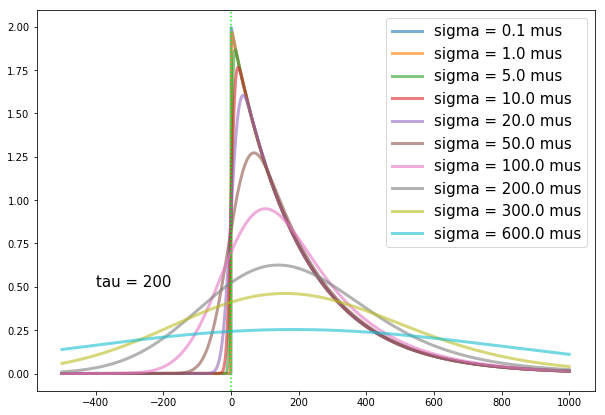

In [331]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper right", fontsize=15)
plt.text(-400,.5,"tau = 200",fontsize=15)
plt.axvline(0,color='lime',linestyle=":")
plt.show()

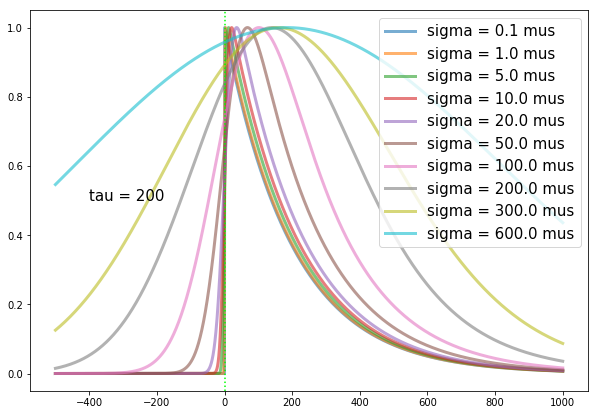

In [340]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xvals*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper right", fontsize=15)
plt.text(-400,.5,"tau = 200",fontsize=15)
plt.axvline(0,color='lime',linestyle=":")
plt.show()

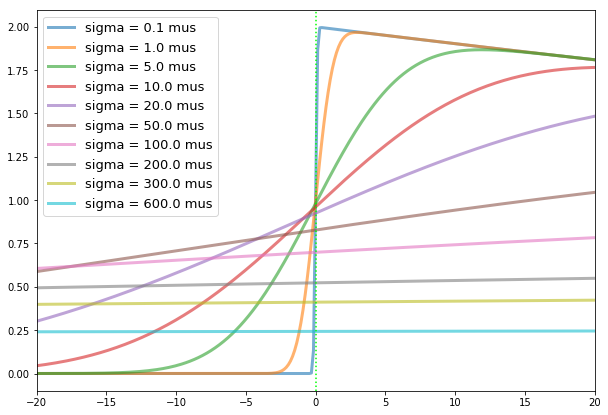

In [332]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,10000)
for x in range(0,len(sigmas)):
    yvals = func(xvals,0,sigmas[x]*1e-6,1,0,200e-6)
    lab = 'sigma = '+str(sigmas[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=13)
plt.axvline(0,color='lime',linestyle=":")
plt.xlim(-20,20)
plt.show()

In [361]:
Taus = np.array([6,10,100,200,400,1000,10000])
#Taus = np.array([5,6,7,8,9,10])

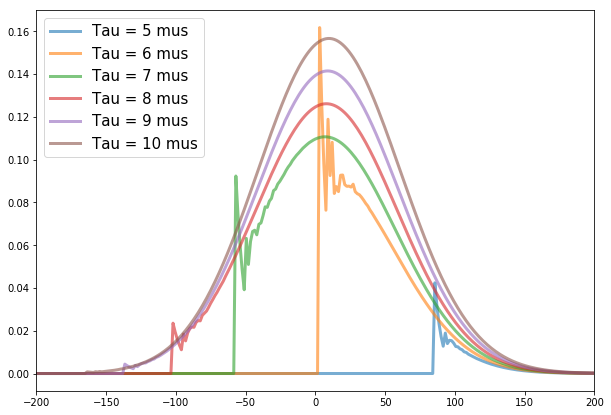

In [345]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.xlim(-200,200)
plt.show()

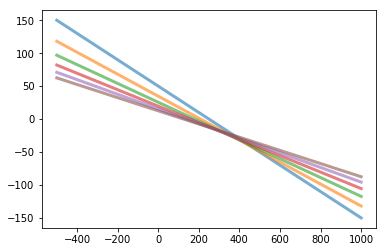

In [359]:
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    E,A,B,C,D = func2(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,A, linewidth=3,alpha=0.6,label=lab)
   # plt.semilogy()

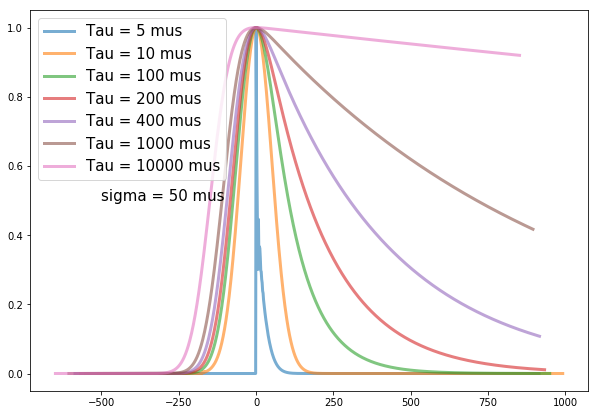

In [338]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xa1*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.show()

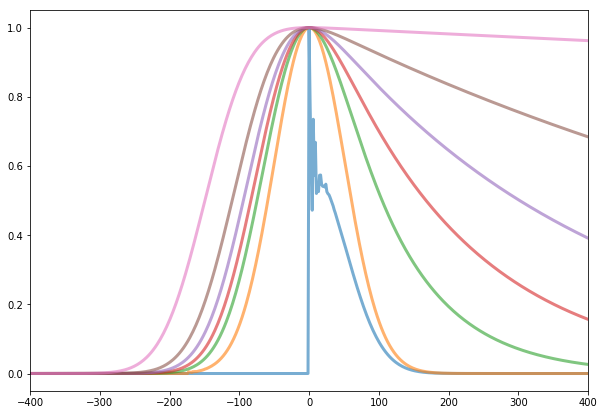

In [362]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    Nor = max(yvals)
    MaxArg=np.argmax(yvals)
    xa1=xvals-xvals[MaxArg]
    plt.plot(xa1*1e6,yvals/Nor, linewidth=3,alpha=0.6,label=lab)

#plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.xlim(-400,400)
plt.show()

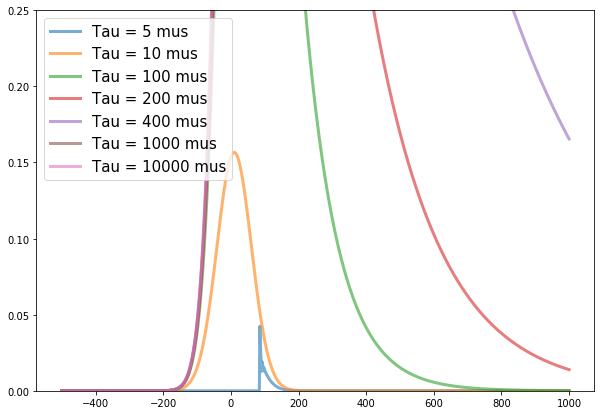

In [322]:
plt.figure(figsize=(10,7))
xvals = np.linspace(-0.5e-3,1e-3,1000)
for x in range(0,len(Taus)):
    yvals = func(xvals,0,50e-6,1,0,Taus[x]*1e-6)
    lab = 'Tau = '+str(Taus[x])+' mus'
    plt.plot(xvals*1e6,yvals, linewidth=3,alpha=0.6,label=lab)

plt.legend(loc="upper left", fontsize=15)
#plt.text(-500,0.5,"sigma = 50 mus",fontsize=15)
plt.ylim(0,0.25)
plt.show()

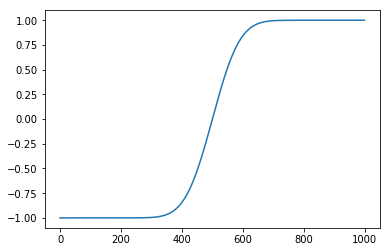

In [347]:
vars=np.arange(-5,5,0.01)
plt.plot(erf(vars))

In [ ]:
PRE[q]

In [ ]:
for x, y, c, m in zip(datas[:,0], datas[:,1], colors, markers)
    ax.scatter(x, y, alpha=0.8, c=c,marker=m) 

In [ ]:
x = [0,1,2]
y = [0,1,2]
m = ['<','s','D']
for x, y, m in zip(x, y, m):
    plt.scatter(x, y, alpha=0.8,marker=m) 

In [ ]:
np.rint(PRE[q])

In [81]:
plt.figure(figsize=(8,8))
#for q in range(0,len(GOLDD)):
for q in range(0,7):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    #SigmaA.append(sig.tolist())

    #dd = 13.49*1e4
    dd = 15.12*1e4
    
    mu = Vd/EFID[q]
    X = REDU[q]#2*dd/(PRE[q]*REDU[q])#DlStar[q]
    ds = 15.12
    t = Dt
    #Y = dd**2/(2*Dt**3)*sig
    Y = (sig*ds**2)/(2*t**3)*1e6 # Dl slash
    DlSlash = Y
    Y = (DlSlash*1e8)
    #Y = ((sig*ds**2)/(2*t**3))/((ds/t)**2) # Dl slash/V**2
    #Y = (sig)/(2*Dt) # Dl
    #Y = sig
    #Y = Dt
    #ds = 151.2
    #Y = ds/t
    VVd = (15.12/Dt)*1e6

    Y = np.sqrt(2*Y/VVd)#*np.sqrt(PRE[q])#*np.sqrt(273/296)
    #sort_index = np.argsort(X)
    #X = X[sort_index]
    #Y = Y[sort_index]
    lab = PERCT[q]+'%Xe'
    plt.scatter(X,Y,label=lab)
    #DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    #Yer = Y*0.1#DlErr
    #plt.errorbar(X,Y,yerr=Yer,fmt='none', capthick=1)
    
    #plt.plot(X,Y)
    #plt.plot(PRE[q],((GOLDD[q][:,1]*1e6))**2,'o')
    #plt.plot(PRE[q],((ANODE[q][:,1]*1e6))**2,'x')
#plt.semilogx()
#plt.loglog()    
#plt.ylim(3e4,5e5)
#plt.ylim(3e6,5e7)

plt.ylim(1200,2200)
#plt.ylim(0.025,1)
plt.xlim(0,230)
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Reduced field",fontsize=20)
#plt.ylabel(r" Dl   ($\sqrt{bar} \mu m / \sqrt{cm}$)",fontsize=20)
plt.ylabel(r" $Dl^*$ slash   ($\mu m / \sqrt{cm}$)",fontsize=20)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/DslashSTAR"+".png")
plt.show()

NameError: name 'Vd' is not defined

<Figure size 576x576 with 0 Axes>

In [ ]:
Y

In [ ]:
PERCT

In [ ]:
sig

In [ ]:
Y/(((ds/t)*1e6)**2)

In [ ]:
DlStar = dict()
DlSerr = dict()
Vel = dict()
VelErr=dict()
REDUerr=dict()
SigmaA = []
SigmaG = []
for q in range(0,len(GOLDD)):

    Dt = (ANODE[q][:,0] - GOLDD[q][:,0])*1e6
    sig = ((ANODE[q][:,1]*1e6))**2 -((GOLDD[q][:,1]*1e6))**2
    gig = ((GOLDD[q][:,1]*1e6))**2
    sig = ((ANODE[q][:,1]*1e6))**2
    SigmaA.append(sig.tolist())
    SigmaG.append(gig.tolist())
    #sig = ((ANODE[:,1]*1e6))**2 

    dd = 13.49*1e4
    dd = 15.12*1e4
    Dlong = sig*0.5*dd**2/Dt**3
    Dlong = sig*dd**2/Dt**3
    Vd = 15.12/Dt
    Vel[q] = 151.2/Dt
    VelErr[q]  = np.sqrt((0.3/15.12)**2+(0.01/PRE[q])**2)
    
    Dlstar = np.sqrt(2*Dlong/Vd)*np.sqrt(PRE[q])*np.sqrt(273/296)
    DlErr  = 0.5*np.sqrt(6*(0.01)**2+3*(0.3/15.12)**2+(0.01/PRE[q])**2)
    DlStar[q] = Dlstar
    DlSerr[q] = DlErr

In [ ]:
SigmaG = [item for sublist in SigmaG for item in sublist]
SigmaA = [item for sublist in SigmaA for item in sublist]

In [ ]:
bb = np.linspace(0,25,30)
plt.hist(SigmaG,bins=bb)
plt.show()


bb = np.linspace(0,1e3,30)
plt.hist(SigmaA,bins=bb)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    ax1.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    ax1.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

ax1.set_xscale('log')
ax1.set_xticks([7,10,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(6,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeArHe/MBV-Error-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
MBZ = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr-Dl.npy")

In [ ]:
len(MBZ)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
len(COL)

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.scatter(REDU[q],DlStar[q],label=PERCT[q],color=COL[q])

    Yer = DlStar[q]*0.027655
    Yer = DlStar[q]*DlSerr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],DlStar[q],xerr=Xer,yerr=Yer,fmt='none', capthick=1,color=COL[q])

        
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0.5e3,5e3)
plt.xlim(0,330)
plt.show()

In [ ]:
len(GOLDD)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,4,6]:
   
    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q])
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,3500)
plt.xlim(0,330)
plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in [0,2,6]:
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)
    
    
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=22,ncol=1)

plt.ylim(400,2100)
plt.xlim(0,230)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/diff"+".png")

plt.show()

In [ ]:
len(DlStar[q]/2)

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
    
    plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
    plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)

    plt.ylim(0,2500)
    plt.xlim(0,330)
    plt.tight_layout()
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

    plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
for q in range(0,len(GOLDD)):
    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'

    plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=lab,s=30)
    
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*VelErr[q]
    #Yer = DlStar[q]/2.355*0.027655
    Yer = DlStar[q]/2.355*0.0422
    Yer = DlStar[q]/2.355*0.098
    Yer = DlStar[q]*DlSerr[q]/2.355

    plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZ[eh1]
    Y = MBZ[eh2]
    Yer = MBZ[eh3]
    #plt.plot(MBZ[eh1],MBZ[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.3, interpolate=True)
    
plt.semilogx()   
plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(500,2500)
plt.xlim(0,330)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/diff"+str(q)+".png")

plt.show()

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-XeAr.npy")

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
#for q in range(0,len(GOLDD)):
for q in [0]:

    lab = PERCT[q]+'%Xe'+' '+str(100-int(PERCT[q]))+'%Ar'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    #Xer = REDU[q]*0.0124479
    Xer = REDU[q]*0.0222
    #Yer = Vel[q]*0.011989
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    #plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor=COL[q],alpha=0.2, interpolate=True)

#plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor=COL[q],fmt='none', capthick=1)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()

plt.grid()
plt.ylim(0,3.8)
#plt.ylim(0,2)

plt.xlim(0,230)
#plt.xlim(0,130)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
len(GOLDD)

In [ ]:
MBZV = np.load("/Users/austinmcdonald/Documents/Gas-physics/MB-Error.npy")


In [ ]:
COL =['b','b','g','g','r','r','m','m','y','y','c','c','k','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,5):
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
plt.ylim(0,3.8)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
#plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    ax1.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    ax1.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    ax1.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)

    
ax1.set_xscale('log')
ax1.set_xticks([7,20,40,60,100, 200, 500])
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
ax1.set_ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
ax1.grid()
ax1.legend(loc='upper right',fontsize=14,ncol=3)

plt.ylim(0,3.4)
plt.xlim(7,300)
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
fig1, ax1 = plt.subplots()
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)-2):
    lab = PERCT[q+1]+'%Xe'+' '+str(100-int(PERCT[q+1]))+'%Ar'
    plt.scatter(REDU[q+1],Vel[q+1],color=COL[q],label=lab)
    Yer = Vel[q+1]*VelErr[q+1]
    Xer = REDU[q+1]*VelErr[q+1]
    plt.errorbar(REDU[q+1],Vel[q+1],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y1 = MBZV[eh2]
    Y2 = MBZV[eh3]
    plt.fill_between(X,Y1,Y2,facecolor=COL[q],alpha=0.2, interpolate=True)
plt.semilogx()

plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
#plt.xticks([50,100,150,200],fontsize=24)
ax1.set_xticks([20, 200, 500])
plt.yticks(fontsize=24)
plt.grid()
plt.legend(loc='upper right',fontsize=14,ncol=3)
plt.tight_layout()
plt.grid()
#plt.semilogy()

plt.ylim(0,3.4)
plt.xlim(0,350)
#plt.savefig("/Users/austinmcdonald/Desktop/Vdrift"+"ALL"+".png")

plt.show()

In [ ]:
COL =['b','g','r','m','y','c','k','lime','orange','steelblue','pink','blue']
plt.figure(figsize=(9,9))
#for q in range(0,len(GOLDD)):
for q in range(0,len(GOLDD)):
    plt.figure(figsize=(9,9))
    lab = PERCT[q]+'%Xe'
    plt.scatter(REDU[q],Vel[q],color=COL[q],label=lab)
    Xer = REDU[q]*0.0222
    Yer = Vel[q]*0.0222
    #Yer = Vel[q]*0.098
    Yer = Vel[q]*VelErr[q]
    Xer = REDU[q]*VelErr[q]
    plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)
    
    eh1 =q*3
    eh2 =q*3+1
    eh3 =q*3+2
    X = MBZV[eh1]
    Y = MBZV[eh2]
    Yer = MBZV[eh3]
    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)
    plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

    #plt.plot(MBZV[eh1],MBZV[eh2],color=COL[q],alpha=0.5,linewidth=2)


    plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
    plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    #plt.xticks(np.arange(0, 400, 50.0))
    plt.grid()
    plt.legend(loc='upper right',fontsize=16,ncol=2)
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,3.8)
    plt.xlim(0,330)
    #plt.savefig("/Users/austinmcdonald/Desktop/Daigo/XeAr/Vdrift"+str(q)+".png")

    plt.show()

In [ ]:
nextVX = [22.932878581189854,28.02632973433397,33.09933408732141,38.31422698545041
          ,43.33941591803868,48.39592788718672,53.49143151000674]
nextVY = [0.8098494025367218, 0.8570545640040048,0.8878392477288395, 0.9132533688888385
         , 0.9312951909452365, 0.9492212516208849, 0.9658736827093846]
print(len(nextVX))
print(len(nextVY))

In [ ]:
nextDX = [22.9,25.9,26.2,28.0,28.3,28.4,29.9,33.2,34.0,37.9,38.0,38.3,42.0,43.4,44.4,47.5,48.6,53.7,57.0]
nextDY = [1357.3, 1213.3, 1167.4, 1161.1, 1320.9, 1195.9, 1105.7, 1058.2, 1034.5, 979.1, 1129.4,
          988.6, 941.1, 939.6, 958.5, 1028.2, 901.6, 869.9, 903.2]
print(len(nextDX))
print(len(nextDY))

In [ ]:
len(GOLDD)

In [ ]:
plt.figure(figsize=(9,9))
q=6
plt.scatter(REDU[q],Vel[q],color=COL[q],label=PERCT[q])
Xer = REDU[q]*0.0222
Yer = Vel[q]*0.0222
#Yer = Vel[q]*0.098
Yer = Vel[q]*VelErr[q]
Xer = REDU[q]*VelErr[q]
plt.errorbar(REDU[q],Vel[q],xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZV[eh1]
Y = MBZV[eh2]
Yer = MBZV[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)



plt.errorbar(nextVX,nextVY,xerr=0,yerr=0.03,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')





plt.xlabel(r'Reduced Drift Field (V/cm/Bar)',fontsize=26)
plt.ylabel(r'Drift Velocity (mm/$\mu$s)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)
plt.tight_layout()

plt.grid()
plt.ylim(0,1.4)
plt.xlim(0,230)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-Vdrift"+".png")

plt.show()

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(REDU[q],DlStar[q]/2.355,color=COL[q],label=PERCT[q],s=30)
Xer = REDU[q]*0.1
Yer = DlStar[q]/2.355*0.098

Xer = REDU[q]*VelErr[q]
#Yer = DlStar[q]/2.355*0.027655
Yer = DlStar[q]/2.355*0.0422
Yer = DlStar[q]/2.355*0.098
Yer = DlStar[q]*DlSerr[q]/2.355
plt.errorbar(REDU[q],DlStar[q]/2.355,xerr=Xer,yerr=Yer,ecolor=COL[q],fmt='none', capthick=1)

eh1 =q*3
eh2 =q*3+1
eh3 =q*3+2
X = MBZ[eh1]
Y = MBZ[eh2]
Yer = MBZ[eh3]
plt.fill_between(X,Y+Yer,Y-Yer,facecolor='k',alpha=0.3, interpolate=True)

plt.errorbar(nextDX,nextDY,xerr=0,yerr=100,ecolor='lime',color='lime',fmt='D', capthick=1,label='NEXT data')



plt.xlabel(r'Reduced Drift Field ( V/cm/Bar )',fontsize=26)
plt.ylabel(r'Longitudinal Diffusion  ( $\sqrt{bar}$*$\mu$m/$\sqrt{cm}$ )',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.legend(loc='upper right',fontsize=16,ncol=2)

plt.ylim(0,2500)
plt.xlim(0,330)
#plt.savefig("/Users/austinmcdonald/Desktop/Daigo/next-diff"+".png")

plt.show()

In [ ]:
PATH = '/Users/austinmcdonald/Desktop/XeAr/Data/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

In [ ]:
'/Users/austinmcdonald/Desktop/XeAr/Data/008/Xe-008_P-01_E-200.txt'

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-01_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,350e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.35,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-2.3,8.1)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()


In [ ]:
opta

In [ ]:
Data = np.loadtxt('/Users/austinmcdonald/Desktop/XeAr/Data/000/Xe-000_P-11_E-200.txt')
xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])

In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
#plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
#plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gau"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.7,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/Gauss"+".png")
plt.show()


In [ ]:
ml = 1
mm = 1e3
plt.figure(figsize=(8,8))
xx = moving_average(xa*ml*ml,10)
yy = moving_average(ya*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Anode")
TriggerTime = find_nearest(xg,0)
Trigger     = np.where(xg==TriggerTime)[0][0]
base   = np.mean(yg[0:Trigger])
xx = moving_average(xg*ml*ml,10)
yy = moving_average((yg-base)*ml,10)
plt.plot(xx*mm*mm,yy*mm,linewidth=2,alpha=0.1,label="Cathode")
plt.xlim(-10e-6*mm*mm,345e-6*mm*mm)
xxx = np.linspace(0,500e-6,1000)
yyy = gaus(xxx,*optg)
plt.plot(xxx*mm*mm,yyy*mm+0.58,linewidth=2,alpha=0.7)
yyy = gaus(xxx,*opta)
plt.plot(xxx*mm*mm,yyy*mm,color='k',linewidth=2,alpha=0.7)
plt.ylim(-1.6,2.9)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel(r'Time ($\mu$s)',fontsize=26)
plt.ylabel(r'Voltage (mlV)',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0, 400, 50.0))
plt.grid()
plt.tight_layout()
#plt.savefig("/Users/austinmcdonald/Desktop/GaussF"+".png")

plt.show()

In [ ]:
# arrival, sigma, max, RC
GOLDD = dict()
ANODE = dict()
REDU  = dict()
PRE   = dict()
EFID  = dict()
PERCT = dict()
for F in range(0,len(folders)):
    for F in range(0,len(folders)):

    GOLDDH = []
    ANODEH = []
    REDUH  = []
    PREH   = []
    EFIDH  = []
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    info = np.loadtxt(folders[F]+'Run-info.txt')
    files.remove('Run-info.txt')
    files.sort()
    for fi in files:
        print(fi)
        Data = np.loadtxt(folders[F]+fi)
        if np.mean(Data[0])!=0:
            xa,ya,opta,chia = FITTER_ANOD(Data[0],Data[2])
            xg,yg,optg,chig = FITTER_GOLD(Data[0],Data[1])
            EE =int(fi.split('.')[0].split('-')[-1])
            PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
            if PP==1:
                PP = info[0]
            elif PP==3:
                PP = info[1]
            elif PP==6:
                PP = info[2]
            elif PP==9:
                PP = info[3]
            elif PP==11 or PP==10:
                PP = info[4]
            PREH.append(PP)
            REDUH.append(EE/PP)
            ANODEH.append(opta)
            GOLDDH.append(optg)
            EFIDH.append(EE)
        
    GOLDD[F] = np.array(GOLDDH)
    ANODE[F] = np.array(ANODEH)
    REDU[F]  = np.array(REDUH)
    PRE[F]   = np.array(PREH)
    EFID[F]   = np.array(EFIDH)
    Prct = folders[F].split('/')[-2]
    PERCT[F] = Prct